In [40]:
import geoengine as ge
from geoengine.workflow_builder.operators import GdalSource, TemporalRasterAggregation, RasterStacker, RenameBands, \
    Expression,RasterTypeConversion, RasterBandDescriptor
from typing import Tuple
import numpy as np
from ipyleaflet import projections
import xarray_leaflet
from xarray_leaflet.transform import passthrough
import matplotlib.pylab as plt

In [8]:
koeln_center_utm = [356766, 5644819]

In [10]:
ge.initialize("http://localhost:3030/api")

In [12]:
def _query_rectangle(*,
                     center: Tuple[float, float],
                     time: np.datetime64,
                     radius_px: float = 512) -> ge.QueryRectangle:
    resolution = ge.SpatialResolution(10, 10)
    bbox = ge.BoundingBox2D(
        xmin=center[0] - resolution.x_resolution * radius_px,
        xmax=center[0] + resolution.x_resolution * radius_px,
        ymin=center[1] - resolution.y_resolution * radius_px,
        ymax=center[1] + resolution.y_resolution * radius_px,
    )
    return ge.QueryRectangle(
        spatial_bounds=bbox,
        time_interval=ge.TimeInterval(time),
        srs='EPSG:32632',
        resolution=resolution,
    )

workflow = TemporalRasterAggregation(
    aggregation_type='mean',
    granularity='months',
    window_size=1,
    ignore_no_data=True,
    source=RasterStacker(
        sources=[
            RasterTypeConversion(
                ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B04"),
                output_data_type="F32",
            ),
            RasterTypeConversion(
                ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B03"),
                output_data_type="F32",
            ),
            RasterTypeConversion(
                ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B02"),
                output_data_type="F32",
            ),
            ge.workflow_builder.blueprints.sentinel2_cloud_free_ndvi(),
        ],
        rename=RenameBands.rename(['red', 'green', 'blue', 'ndvi']),
    )
)

workflow = ge.register_workflow(workflow)

query_rectangle = _query_rectangle(
        center=koeln_center_utm,
        time=np.datetime64("2022-07-01T00:00:00"),
        radius_px=512,
    )

data_array = await workflow.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0,1,2], # TODO: improve for user, default = all? where are the band names?
)


/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


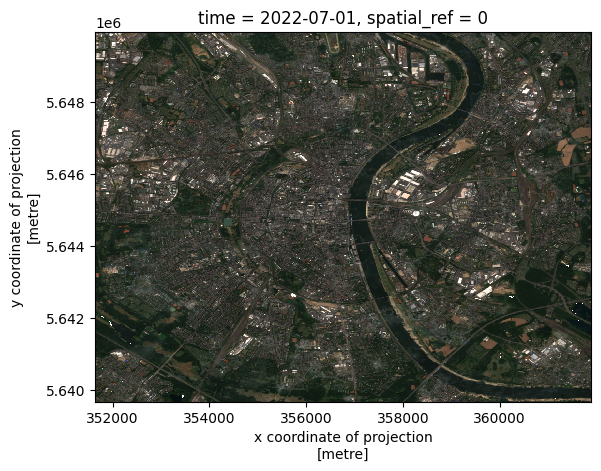

In [15]:
data_array.isel(time=0).plot.imshow(
    rgb="band",
    vmax=4000,
)

In [52]:
from matplotlib.backend_bases import MouseButton

%matplotlib notebook

def on_click(event):
    #if event.button is MouseButton.LEFT:
    print(event)

fig, ax = plt.subplots()

data_array.isel(time=0).plot.imshow(
    rgb="band",
    vmax=4000,
    ax=ax,
)

fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

In [34]:
epsg_32632 = {
    "name": "EPSG:32632",
    "custom": True,  # This is important, it tells ipyleaflet that this projection is not on the predefined ones.
    "proj4def": "+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs +type=crs",
    "origin": [500000.0, 4649776.22],
    "bounds": [[166021.44, 0.0], [833978.56, 9329005.18]],
}

In [36]:
# create mapping widget with sattelite map
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, projections

# switch the base map here
watercolor = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
m = Map(layers=(), center=(0, 9), zoom=3, crm=epsg_32632) 
draw_control = DrawControl()

# disable everything but markers
draw_control.polygon = {}
draw_control.polyline = {}
draw_control.circle = {}
draw_control.circlemarker = {}
draw_control.marker = {"repeatMode": True}

# save map features to a dictionary
feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

def handle_draw(self, action, geo_json):
    """Do something with the GeoJSON when it's drawn on the map"""    
    feature_collection['features'].append({
        "type": "Feature",
        "geometry": geo_json['geometry'],
    })

draw_control.on_draw(handle_draw)

m.add_control(draw_control)

data_array.isel(band=0, time=0).leaflet.plot(
    m,
    #transform2=passthrough,
    fit_bounds=False,
)

m

Url()

Map(center=[0, 9], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [19]:
print(feature_collection)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-253.945313, 39.45886]}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-223.535156, 50.139395]}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-246.738281, 55.941029]}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-224.941406, 38.639802]}}]}
